In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
# from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm       import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from kirchhoff import Kirchhoff

# MODEL, GEOM AND SOURCE DEFINITON - for now single sources

In [2]:
# Velocity Model
nx, nz = 101, 101
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 750 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Microseismic sources
xmicro = [nx//4, nx//2,  3*(nx//4), ]
zmicro = [nz//4, nz//2,  3*(nz//4), ]
ampmicro = [1,1,1]
ns = len(zmicro)

microseismic = np.zeros((ns, nx, nz))
event_dictionary = []
for ev in range(ns):
    microseismic[ev, xmicro[ev], zmicro[ev]] = ampmicro[ev]
    event_dictionary.append({'event':ev,
                             'sx':xmicro[ev],
                             'sz':zmicro[ev],
                             'amp':ampmicro[ev],
                            })

In [3]:
# Define Receiver grid as lines in X and Z
nr_z = 1
nr_x = 50
rec_string = '%i-by-%i'%(nr_x,nr_z)

rec_buffer = 2 
r_z_locs = np.linspace(rec_buffer*dz, (nz-rec_buffer)*dz, nr_z)
r_x_locs = np.linspace(rec_buffer*dx, (nx-rec_buffer)*dx, nr_x)

rx, rz = np.meshgrid(r_x_locs,r_z_locs)
recs = np.vstack((rx.flatten(), rz.flatten()))
nr = recs.shape[1]
# dr = recs[0,1]-recs[0,0]

# MAKE DATA

In [4]:
nt = 451
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)


In [5]:
# INITIALISE OPERATOR
Op = Kirchhoff(z, x, t, recs[:, :1], recs, v0, wav, wavc, mode='analytic', engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=1112.4539129323884 - u^H(Op^Hv)=1112.453912932387


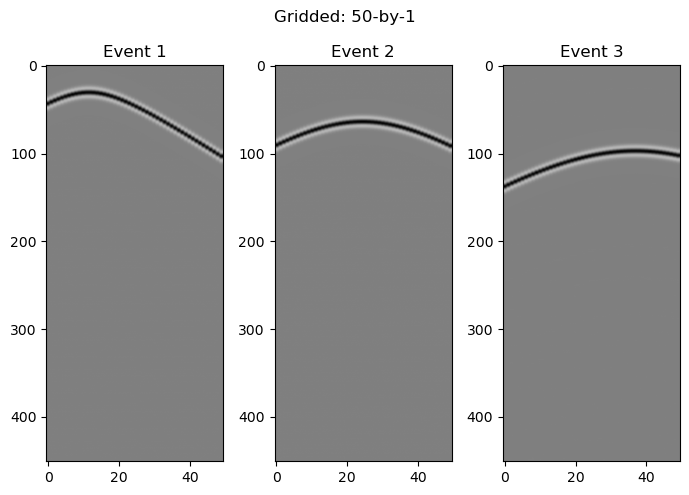

In [6]:
# PERFORM FORWARD (MODEL)
leftEv_fulldata = Op @ microseismic[0].squeeze()
midEv_fulldata = Op @ microseismic[1].squeeze()
rightEv_fulldata = Op @ microseismic[2].squeeze()

fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(leftEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(midEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(rightEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[0].set_title('Event 1')
axs[1].set_title('Event 2')
axs[2].set_title('Event 3')
plt.suptitle('Gridded: %s'%rec_string)
plt.tight_layout()

In [7]:
def add_spatiotemporal_noise(d, sc=0.5, npix=5):
    sigman = 1
    nnr = filtfilt(np.ones(npix) / npix, 1,
                   filtfilt(np.ones(npix) / npix,
                            1,
                            np.random.normal(0, sigman, (d.shape[0], d.shape[1])).T,
                            method='gust').T,
                   method='gust')
    n = nnr / np.max(abs(nnr))

    return d + (n * sc), n

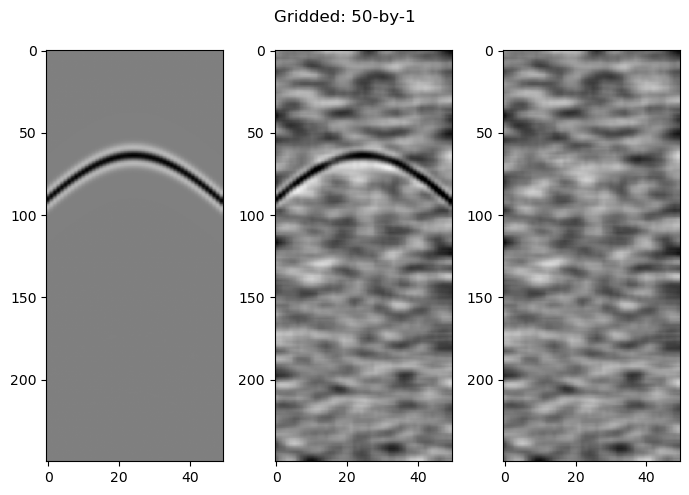

In [8]:
w = midEv_fulldata[:,:250]
d,n = add_spatiotemporal_noise(w, sc=1)

fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(w.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(d.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(n.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
plt.suptitle('Gridded: %s'%rec_string)
plt.tight_layout()

[]

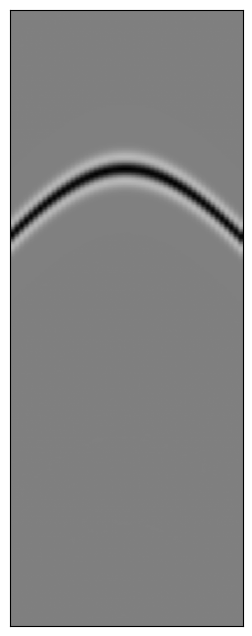

In [9]:
fig,axs = plt.subplots(1,1,figsize=[3,8])
axs.imshow(w.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs.set_yticks([]); axs.set_xticks([])